In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebook':
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from preprocessing import (
    load_raw_data,
    clean_data,
    add_features,
    encode_categoricals,
    split_features_target,
)


In [36]:
# Import opzionali (XGBoost/SHAP)
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except Exception as e:
    XGBOOST_AVAILABLE = False
    XGBRegressor = None
    print(f'XGBoost non disponibile: {e}')

try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    shap = None
    print(f'SHAP non disponibile: {e}')


In [37]:
#Caricamento del dataset
df = load_raw_data()

#Anteprima delle prime righe del dataset
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
#Informazioni generali: num righe e colonne, tipi di variabili, valori null
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   str    
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   str    
 6   Alley          91 non-null     str    
 7   LotShape       1460 non-null   str    
 8   LandContour    1460 non-null   str    
 9   Utilities      1460 non-null   str    
 10  LotConfig      1460 non-null   str    
 11  LandSlope      1460 non-null   str    
 12  Neighborhood   1460 non-null   str    
 13  Condition1     1460 non-null   str    
 14  Condition2     1460 non-null   str    
 15  BldgType       1460 non-null   str    
 16  HouseStyle     1460 non-null   str    
 17  OverallQual    1460 non-null   int64  
 18  OverallCond    1460

In [39]:
#Statistiche relative alle variabili numeriche
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [40]:
#Analisi dei valori mancanti con ordinamento colonne per numero di NaN
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

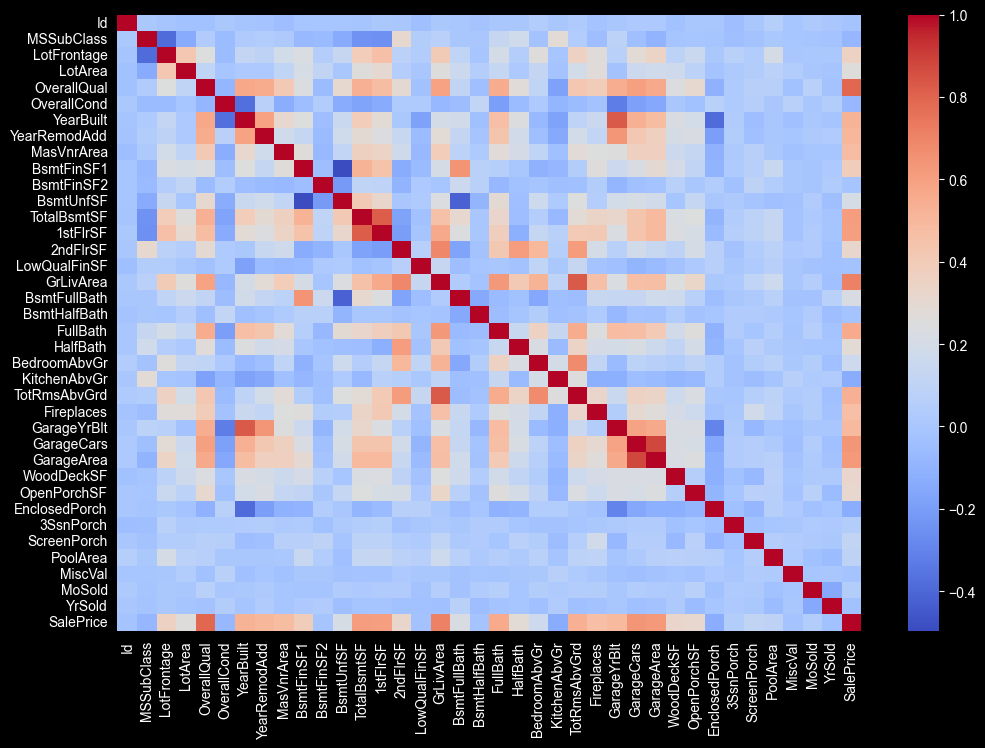

In [41]:
#Matrice di correlazione
corr = df.corr(numeric_only=True)
#Visualizzazione delle variabili correlate tra loro
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm")
plt.show()

In [42]:
#PULIZIA DATI E IMPUTAZIONE VALORI MANCANTI
df = clean_data(df)

#FEATURE ENGINEERING
df = add_features(df)


In [43]:
#Controllo valori mancanti residui
df.isnull().sum().sort_values(ascending=False).head(10)

Id              0
MSSubClass      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

In [44]:
#Num totale di valori mancanti nel dataset
df.isnull().sum().sum()

np.int64(0)

In [45]:
#Statistiche post-pulizia
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HouseAge,RemodAge,TotalSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.199658,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,36.547945,22.950000,2567.048630
std,421.610009,42.300571,22.431902,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,30.250152,20.640653,821.714421
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,-1.000000,334.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,8.000000,4.000000,2009.500000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,35.000000,14.000000,2474.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,54.000000,41.000000,3004.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,136.000000,60.000000,11752.000000


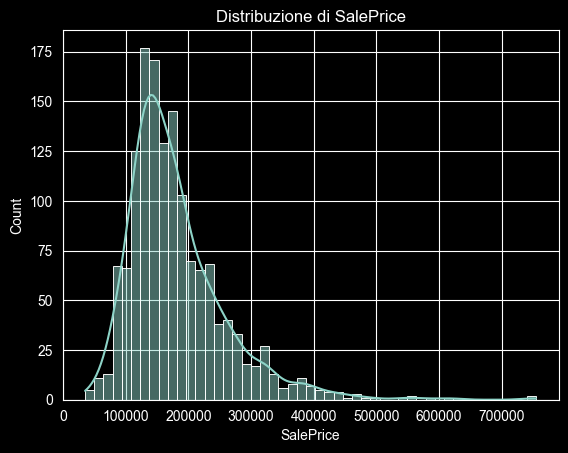

In [46]:
#Istogramma per la distribuzione della variabile target SalePrice
sns.histplot(df["SalePrice"], kde=True)
plt.title("Distribuzione di SalePrice")
plt.show()

In [47]:
#Analisi correlazione tra variabili numeriche e SalePrice
corr = df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)
corr.head(15)

SalePrice       1.000000
OverallQual     0.790982
TotalSF         0.782260
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

In [48]:
#Codifica variabili categoriche in numeriche
df_encoded = encode_categoricals(df, drop_first=True)

#Separazione tra feature (X) e target (y)
X, y = split_features_target(df_encoded, target='SalePrice', log_target=True)

df_encoded.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,False,True,False,False,False,True,False


In [49]:
# TRAINING PIPELINE
from models.train_pipeline import train_and_evaluate

results_df, trained_models, (X_train, X_test, y_train, y_test) = train_and_evaluate(
    use_xgboost=XGBOOST_AVAILABLE,
    save_best=True,
    return_data=True
)

results_df

# Modello XGBoost (se disponibile)
xgb = trained_models.get('XGBoost')
if xgb is None:
    print('XGBoost non disponibile o non addestrato.')


Modello salvato in: /Users/Luigi/Documents/Programmi/PyCharm/PriceMyHouse/models/artifacts/xgboost.joblib


In [50]:
# PREDIZIONE SU ESEMPIO Casa 1
if not XGBOOST_AVAILABLE or 'xgb' not in globals() or xgb is None:
    print('XGBoost non disponibile, salto questa cella.')
else:


    # Selezioniamo la prima casa del test set
    sample = X_test.iloc[0:1]
    pred_log = xgb.predict(sample)
    pred_price = np.expm1(pred_log)
    pred_price

In [51]:
# Visualizziamo le feature della casa per interpretare la predizione
X_test.iloc[0:1].T

,892
Id,893
MSSubClass,20
LotFrontage,70.0
LotArea,8414
OverallQual,6
...,...
SaleCondition_AdjLand,False
SaleCondition_Alloca,False
SaleCondition_Family,False
SaleCondition_Normal,True


In [52]:
# PREZZO REALE DELLA PRIMA CASA DEL TEST SET
true_log_price = y_test.iloc[0]
true_price = np.expm1(true_log_price)
true_price

np.float64(154500.00000000012)

In [53]:
# IMPORTANZA DELLE FEATURE SECONDO XGBOOST
if not XGBOOST_AVAILABLE or 'xgb' not in globals() or xgb is None:
    print('XGBoost non disponibile, salto questa cella.')
else:

    import pandas as pd

    # Calcolo dell'importanza delle feature dal modello
    importance = xgb.get_booster().get_score(importance_type='gain')

    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    })

    # Se XGBoost usa feature index (f0, f1, ...), mappa agli effettivi nomi colonna
    if importance_df['Feature'].str.match(r'^f\d+$').all():
        importance_df['Index'] = importance_df['Feature'].str.extract(r'^f(\d+)$').astype(int)
        importance_df['FeatureName'] = importance_df['Index'].apply(lambda i: X.columns[i])
    else:
        # Altrimenti le feature sono già nominate
        importance_df['FeatureName'] = importance_df['Feature']

    # Ordina per importanza
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    importance_df


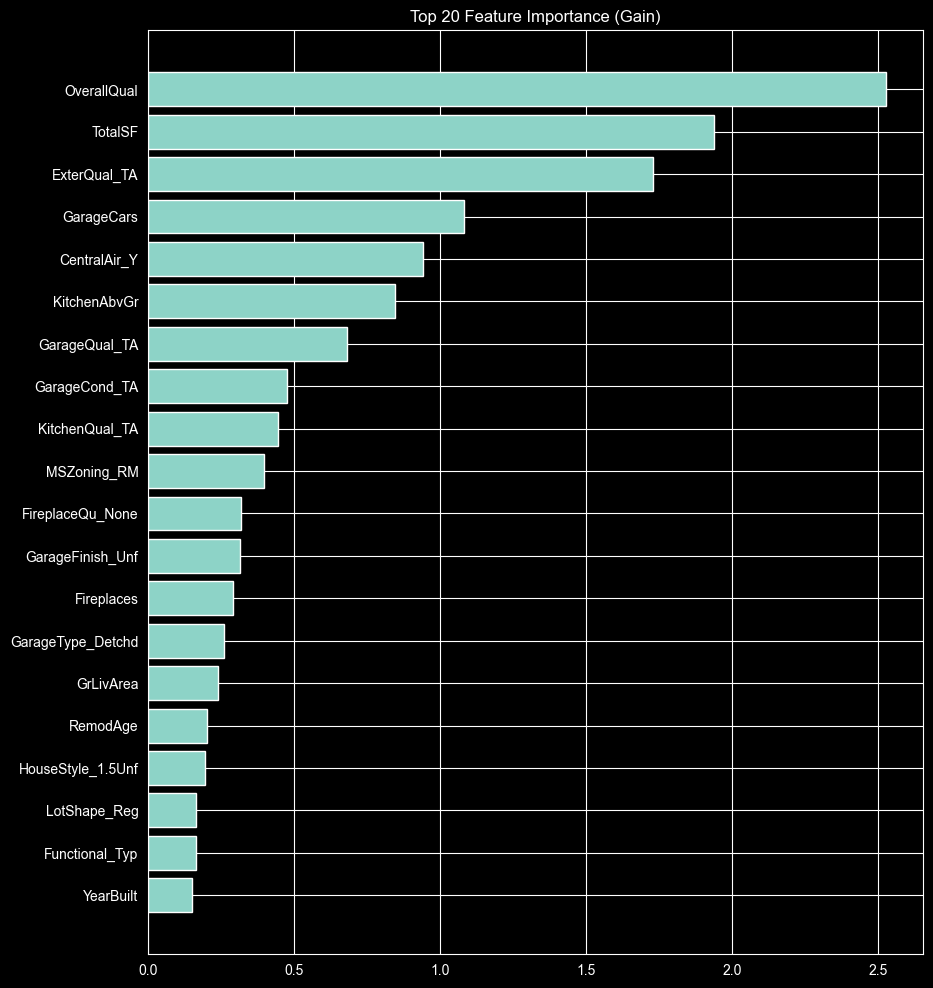

In [54]:
# GRAFICO DELLE TOP 20 FEATURE
plt.figure(figsize=(10, 12))
plt.barh(importance_df['FeatureName'].head(20), importance_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance (Gain)")
plt.show()

In [55]:
# Installazione/aggiornamento di ipywidgets (opzionale)
# !pip install ipywidgets --upgrade


In [56]:
# SHAP (TreeExplainer)
if not SHAP_AVAILABLE or 'xgb' not in globals() or xgb is None:
    print('SHAP o XGBoost non disponibile, salto questa cella.')
else:
    explainer = shap.TreeExplainer(xgb)

    # Calcoliamo i valori SHAP per il test set
    shap_values = explainer.shap_values(X_test)


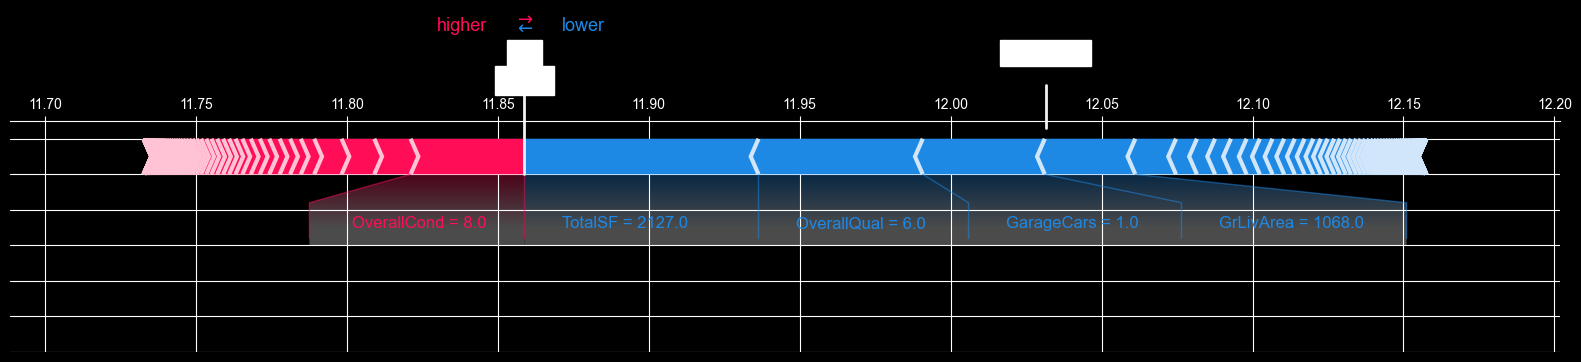

In [57]:
# FORCE PLOT per la prima casa del test set
if not SHAP_AVAILABLE or 'shap_values' not in globals() or 'explainer' not in globals():
    print('SHAP non disponibile o valori non calcolati, salto questa cella.')
else:
    shap.force_plot(
        explainer.expected_value,
        shap_values[0,:],
        X_test.iloc[0,:],
        matplotlib=True
    )


In [58]:
# PREDIZIONE SU ESEMPIO Casa 2
if not XGBOOST_AVAILABLE or 'xgb' not in globals() or xgb is None:
    print('XGBoost non disponibile, salto questa cella.')
else:

    sample = X_test.iloc[1:2]
    pred_log = xgb.predict(sample)
    pred_price = np.expm1(pred_log)
    pred_price

In [59]:
# Visualizziamo le feature della casa per interpretare la predizione
X_test.iloc[1:2].T

,1105
Id,1106
MSSubClass,60
LotFrontage,98.0
LotArea,12256
OverallQual,8
...,...
SaleCondition_AdjLand,False
SaleCondition_Alloca,False
SaleCondition_Family,False
SaleCondition_Normal,True


In [60]:
# PREZZO REALE DELLA SECONDA CASA DEL TEST SET
true_log_price = y_test.iloc[1]
true_price = np.expm1(true_log_price)
true_price

np.float64(324999.9999999999)

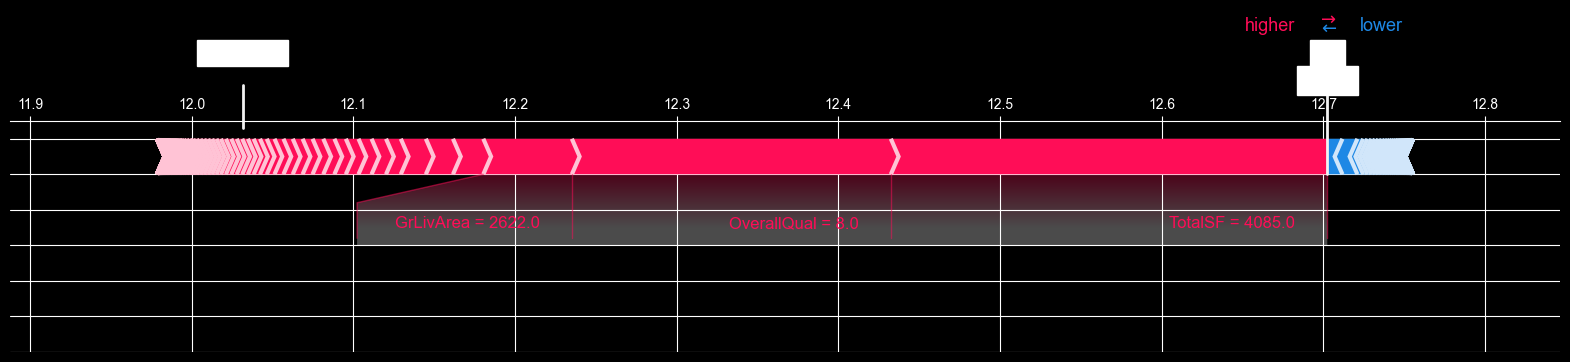

In [61]:
# FORCE PLOT SHAP PER LA SECONDA CASA
if not SHAP_AVAILABLE or 'shap_values' not in globals() or 'explainer' not in globals():
    print('SHAP non disponibile o valori non calcolati, salto questa cella.')
else:
    shap.force_plot(
        explainer.expected_value,
        shap_values[1,:],
        X_test.iloc[1,:],
        matplotlib=True
    )


Casa 1


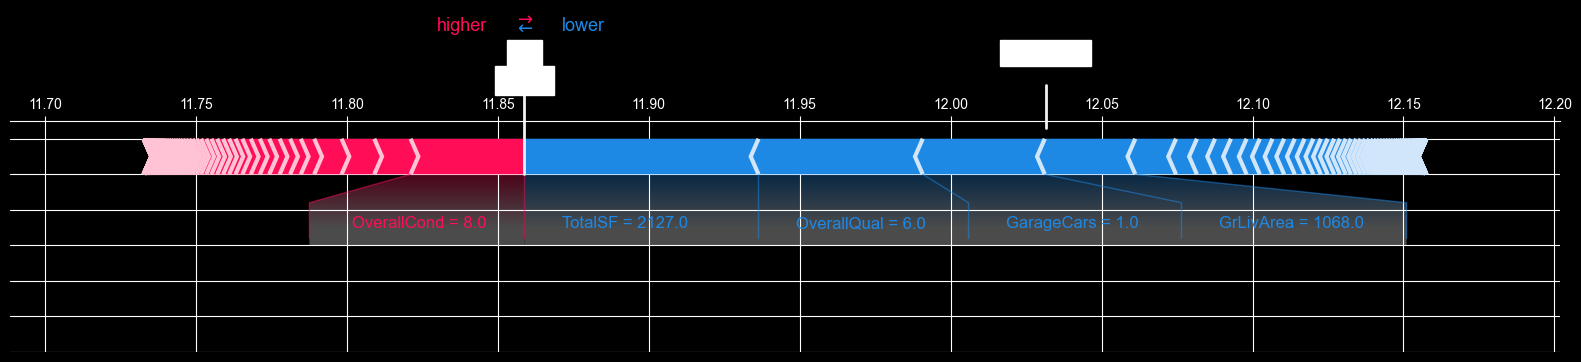

Casa 2


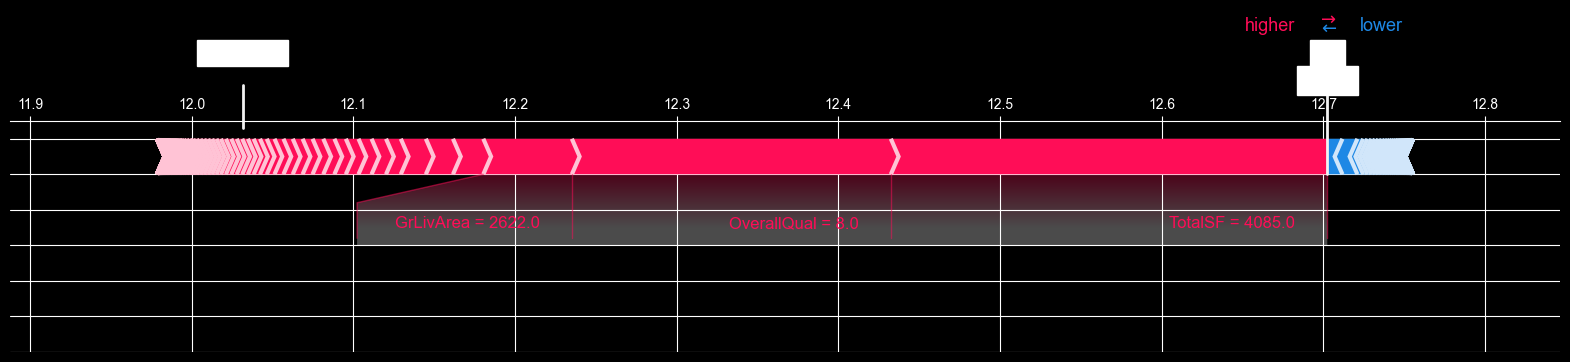

In [62]:
# FORCE PLOT PER CASA 1 E CASA 2
if not SHAP_AVAILABLE or 'shap_values' not in globals() or 'explainer' not in globals():
    print('SHAP non disponibile o valori non calcolati, salto questa cella.')
else:
    # Casa 1
    print('Casa 1')
    shap.force_plot(
        explainer.expected_value,
        shap_values[0,:],
        X_test.iloc[0,:],
        matplotlib=True
    )

    # Casa 2
    print('Casa 2')
    shap.force_plot(
        explainer.expected_value,
        shap_values[1,:],
        X_test.iloc[1,:],
        matplotlib=True
    )


<Figure size 1000x800 with 0 Axes>

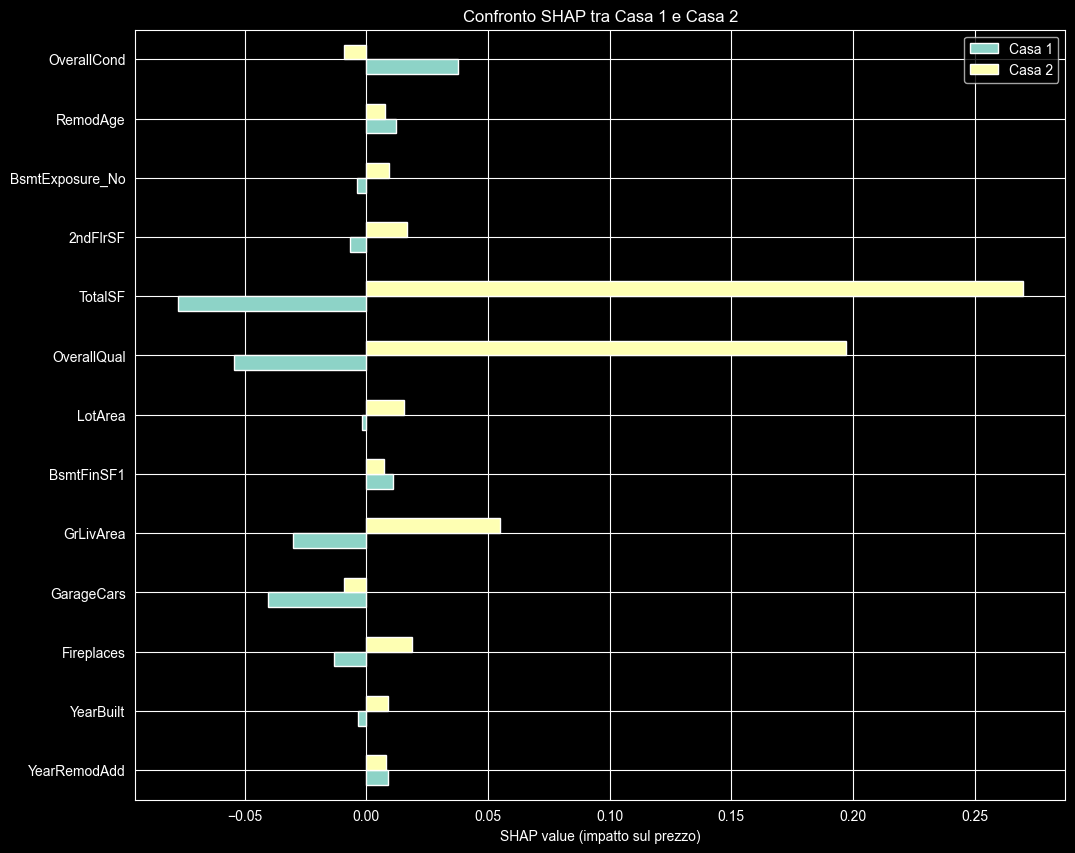

In [63]:
# CONFRONTO SHAP TRA LE DUE CASE
if not SHAP_AVAILABLE or 'shap_values' not in globals() or 'explainer' not in globals():
    print('SHAP non disponibile o valori non calcolati, salto questa cella.')
else:
    import pandas as pd
    import matplotlib.pyplot as plt

    # Indici delle due case
    i1 = 0
    i2 = 1

    # Conversione dei valori SHAP in serie Pandas
    shap1 = pd.Series(shap_values[i1], index=X_test.columns)
    shap2 = pd.Series(shap_values[i2], index=X_test.columns)

    # Selezione delle 10 feature più influenti per ciascuna casa
    top1 = shap1.abs().sort_values(ascending=False).head(10)
    top2 = shap2.abs().sort_values(ascending=False).head(10)

    # Unione delle feature più importanti
    features = list(set(top1.index) | set(top2.index))

    # Dataframe confronto
    df_compare = pd.DataFrame({
        'Casa 1': shap1[features],
        'Casa 2': shap2[features]
    })

    # Grafico comparativo
    plt.figure(figsize=(10, 8))
    df_compare.plot(kind='barh', figsize=(12, 10))
    plt.title('Confronto SHAP tra Casa 1 e Casa 2')
    plt.xlabel('SHAP value (impatto sul prezzo)')
    plt.show()


In [64]:
import os

os.makedirs("../data/processed", exist_ok=True)

In [65]:
df.to_csv("../data/processed/cleaned_data.csv", index=False)

In [66]:
df_encoded.to_csv("../data/processed/df_encoded.csv", index=False)
print("df_encoded.csv salvato in data/processed/")

df_encoded.csv salvato in data/processed/


## Conclusioni Finali

Il progetto aveva l’obiettivo di costruire un modello in grado di prevedere il prezzo delle case nel dataset Ames Housing.
Attraverso un processo completo di analisi, pulizia, feature engineering e modellazione, siamo arrivati a un risultato solido e interpretabile.

### Prestazioni dei modelli
Sono stati confrontati diversi algoritmi di regressione:

- **Linear Regression** (baseline)
- **Random Forest**
- **Gradient Boosting**
- **XGBoost**

Il modello con le migliori prestazioni è risultato essere **XGBoost**, che ha ottenuto l’RMSE più basso sul test set, dimostrando una capacità superiore nel catturare relazioni non lineari e interazioni tra le variabili.

### Feature più importanti
Dall’analisi dell’importanza delle feature e dai valori SHAP, emergono come più influenti:

- **OverallQual** (qualità generale della casa)
- **GrLivArea** (superficie abitabile sopra il livello del suolo)
- **TotalSF** (superficie totale, creata tramite feature engineering)
- **GarageCars** (capacità del garage)
- **YearBuilt / HouseAge** (età della casa)
- **Neighborhood** (zona di appartenenza)

Queste variabili risultano determinanti nel definire il valore di mercato di un’abitazione.

### Interpretazione con SHAP
L’utilizzo di SHAP ha permesso di:

- comprendere come ogni feature contribuisce alla predizione del modello
- analizzare singole case tramite force plot
- confrontare due abitazioni e osservare differenze nei fattori che aumentano o diminuiscono il prezzo

Questo rende il modello non solo accurato, ma anche **interpretabile**, un aspetto fondamentale in ambito immobiliare.

### Considerazioni finali
Il progetto dimostra che:

- un’adeguata fase di preprocessing e feature engineering migliora significativamente le prestazioni
- modelli avanzati come XGBoost offrono ottimi risultati su dati strutturati
- strumenti di interpretabilità come SHAP sono essenziali per comprendere e comunicare le decisioni del modello

### Possibili sviluppi futuri
- Ottimizzazione degli iperparametri tramite Grid Search o Bayesian Optimization
- Aggiunta di nuove feature derivate (es. interazioni tra variabili)
- Validazione incrociata per una stima più robusta delle prestazioni
- Sviluppo di un’interfaccia (web o CLI) per effettuare predizioni su nuove case

Il modello finale rappresenta una base solida per un sistema di valutazione immobiliare accurato e interpretabile.